In [ ]:
import cv2
import math
import statistics
import collections 
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import time
import numpy.ma as ma
import sys

In [ ]:
%cd ~/Documents/CSC420/A2/

/home/john/Documents/CSC420/A2


# Part 1: Seam Carving

In [ ]:
def sobel_image(image):
  input_dtype = image.dtype
  dims = image.shape
  H, W = dims[0], dims[1]
  
  output_image = np.zeros(shape=(H, W))

  sobel_imagex = cv2.Sobel(image,cv2.CV_64F,1,0,ksize=3)
  sobel_imagey = cv2.Sobel(image,cv2.CV_64F,0,1,ksize=3)


  # using this to help speed up the process, rather that using the square root 
  output_image = np.abs(sobel_imagex[:,:, 0]) + np.abs(sobel_imagey[:,:, 0]) + \ 
                  np.abs(sobel_imagex[:,:, 1]) + np.abs(sobel_imagey[:,:,1]) + \ 
                  np.abs(sobel_imagex[:,:, 2]) + np.abs(sobel_imagey[:,:, 2])

  output_image = (output_image/ np.ndarray.max(output_image))*255
  return output_image


# Find the longest path length
def dyn_path (matrix):

  H, W = matrix.shape
  memory = np.zeros(shape=(H, W), dtype= np.float32)
  paths  = np.zeros(shape=(H, W), dtype = np.int8)

  # Find the min_path_length and the directions 
  for j in range(0, W):
    for i in range(0, H): 
      values  = list()

      if (j == 0):
        memory[i,j] = matrix[i,j]
        paths[i,j] = 100
      
      else: 
        value = memory[i,j-1]
        direction = 0  

        if i > 0 and memory[i-1, j-1] < value :
          value = memory[i-1, j-1]
          direction = -1 

        if i < (H-1) and memory[i+1, j-1] < value : 
          value = memory[i+1, j-1]
          direction = 1

        memory[i,j] = value + matrix[i,j]
        paths[i,j] = direction
  
  # add a default path 
  value = math.inf
  cordinate = (0,0) 

  path = list()
  

  # find the min_path_length  
  for i in range (0, H-1):
    if memory[i,W-1] < value: 
      value= memory[i,W-1]
      coordinate = (i,W-1)

  # find the min_path 
  path.append(coordinate)
  for j in range(W-2, -1, -1 ):
    new_cord = (coordinate[0] + paths[coordinate], j)
    path.append(new_cord)
    coordinate = new_cord 

  path.reverse()
  return path


# Remove the path from the image 
def delete_path(image, path):
  dims = image.shape
  H, W = dims[0], dims[1]

  column = list()
  coord = path[0][0]
  path_i = 1
  output_image = list()

  i = 0
  j = 0 
  while j <= W -1:
    if (coord != i ):
      column.append(image[i,j])

    i+= 1 

    if i == H:
      output_image.append(column)
      column=list()
      if path_i < W: 
        coord = path[path_i][0]
        path_i += 1 
      i = 0   
      j += 1 

  output_image = np.array(output_image).T 
  return output_image


def remove_rows (image,  rows):
  
  paths = list()
  dims = image.shape
  input_dtype = image.dtype
  H, W = dims[0], dims[1]
  iterator = image

  sobel = sobel_image(iterator)

  print("Row progress, " , end ='')
  i = 10 
  for row in range (0, rows ):
    if (row)/rows*100 > i: 
      print()
      i+= 10 

    print(f"{(row)/rows*100}%", end='')
    placeholder = np.zeros(shape=(H - row -1 , W , 3 ), dtype = input_dtype)
    path = dyn_path(sobel)
    paths.append(path)

    for color in range(0, 3):
       placeholder[:, :, color] = delete_path(iterator[:,: ,color], path)
    
    sobel = sobel_image(placeholder)
    iterator = placeholder 

  return iterator 


Hello world


99.15074309978769%99.36305732484077%99.57537154989384%99.78768577494692%

Text(0.5, 1.0, 'Image 2')

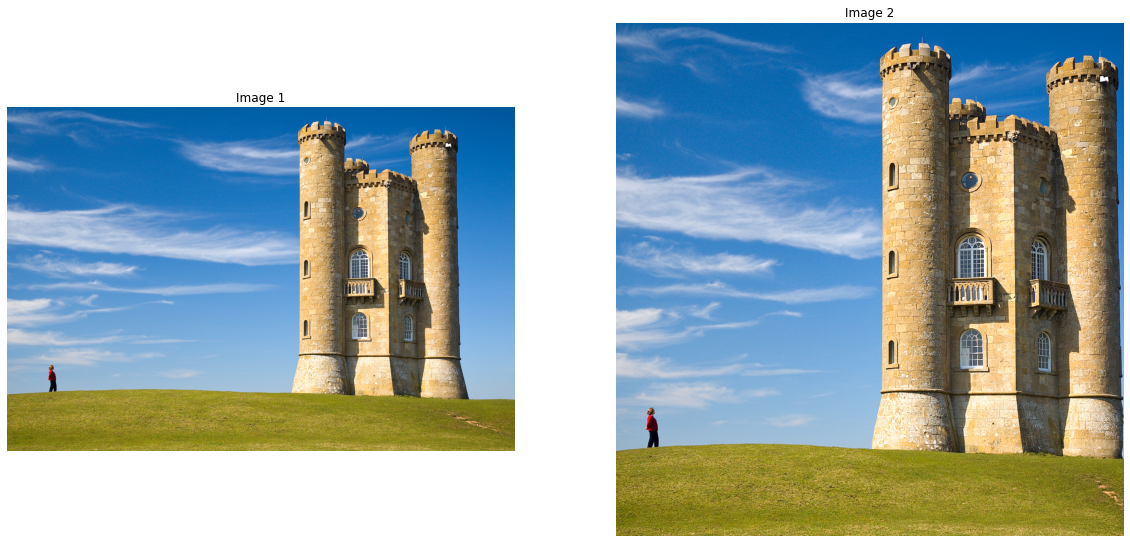

In [ ]:
image = cv2.imread('ex1.jpg')[...,::-1]

plt.figure(figsize=(20,35))
dims = image.shape 
H, W = dims[0], dims[1]

rows_removed = H - 968
columns_removed = W - 957

plt.subplot(1,2,1)
plt.imshow(image)
plt.axis('off')
plt.title('Image 1')


image = remove_rows(image, rows_removed)
image = cv2.transpose(image)
image = remove_rows(image, columns_removed)
image = cv2.transpose(image)

cv2.imwrite("ex1_highres_seamed.jpg", cv2.cvtColor(image, cv2.COLOR_RGB2BGR))


plt.subplot(1,2,2)
plt.imshow(image, cmap = 'gray')
plt.axis('off')
plt.title('Image 2')


In [ ]:
image_lowres = cv2.imread('ex1_lowres.jpg')[...,::-1]

plt.figure(figsize=(20,35))
dims = image_lowres.shape 
H, W = dims[0], dims[1]

rows_removed = 0
columns_removed = 30 

plt.subplot(2,3,1)

plt.imshow(image_lowres, cmap='gray')
plt.axis('off')
plt.title('Image 1')



plt.subplot(2,3,2)

plt.imshow(sobel_image(image_lowres))
plt.axis('off')
plt.title('Image 1')


image_lowres = cv2.transpose(image_lowres)
image = remove_rows(image_lowres,30)

cv2.imwrite("ex1_lowres_seamed.jpg", cv2.cvtColor(image, cv2.COLOR_RGB2BGR))

plt.subplot(2,3,3)
plt.imshow(cv2.transpose(image), cmap = 'gray')
plt.axis('off')
plt.title('Image 2')


In [ ]:
array = np.array( [[3,2,1,4], [2,3,41,1], [1,3,4,6], 
                   [3,1,35,5]])
path = dyn_path(array)
print(path)
print(delete_path(array, path))

# Part 2: Corner Detection 

In [ ]:
# Calculating the I_xx, I_yy, I_xy is entirely based 
# on logic from the lectures 
def M_values(image, ksize, variance ):

  image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

  input_dtype = image.dtype
  dims = image.shape
  H, W = dims[0], dims[1]
  
  # calculate I_xx I_yy and I_xy 
  sobel_imagex = cv2.Sobel(image,cv2.CV_64F,1,0,ksize=3)
  sobel_imagexx = np.multiply (sobel_imagex, sobel_imagex )

  sobel_imagey = cv2.Sobel(image,cv2.CV_64F,0,1,ksize=3)
  sobel_imageyy = np.multiply(sobel_imagey,sobel_imagey )

  sobel_imagexy = np.multiply (sobel_imagex, sobel_imagey) 

  # Adding the window function is essentially a Gaussian blur
  # this should give us the values needed for the M matrix  
  I_yy = cv2.GaussianBlur(sobel_imageyy,(ksize,ksize), variance) 
  I_xx = cv2.GaussianBlur(sobel_imagexx,(ksize, ksize), variance)
  I_xy = cv2.GaussianBlur(sobel_imagexy,(ksize, ksize), variance)

  return I_yy, I_xx, I_xy


def eigenvalues(image, size , variance ):
  dims = image.shape
  H, W = dims[0], dims[1]

  I_yy, I_xx, I_xy = M_values(image, size,variance  )


  lambda_1 = list()
  lambda_2 = list()
  for i in range(0,H):
    for j in range(0,W):
      M = np.zeros(shape=(2,2))
      M[0,0] = I_xx [i,j]
      M[0,1] = I_xy [i,j]
      M[1,0] = I_xy [i,j]
      M[1,1] = I_yy [i,j]

      w,v = np.linalg.eig(M)
      # we know w is the eigenvalues 
      lambda_1.append(w[0])
      lambda_2.append(w[1])

  return lambda_1, lambda_2


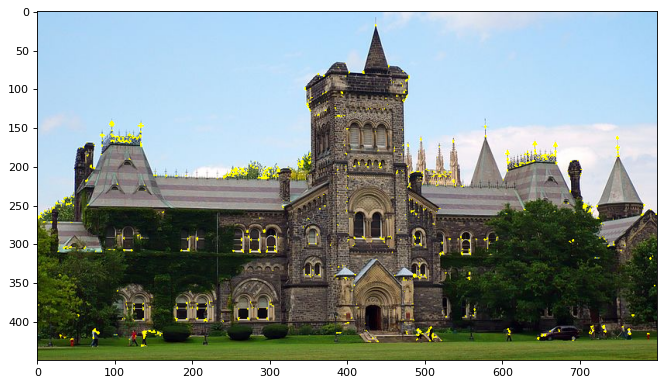

In [ ]:
image = cv2.imread("3_1.jpg")
dims = image.shape
H, W = dims[0], dims[1]

figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')
lambda_1, lambda_2 = eigenvalues(image, 3 , 1 ) 

plt.scatter(lambda_1 , lambda_2)
plt.show 
plt.savefig("3_1_7_10_scatter.jpg")

# Let us use the top 3% of eigenvalues, assuming that 3% of the points would be 
# corners 
lambda_1 = np.array(lambda_1)
lambda_1 = lambda_1.reshape((H, W))
lambda_2 = np.array(lambda_2)
lambda_2 = lambda_2.reshape((H, W))

min_lambda = np.minimum(lambda_1 , lambda_2)
percentile = np.percentile(min_lambda,99)

image2 = image.copy()
image2[min_lambda > percentile] = [0, 255,255]
image2 = cv2.cvtColor(image2, cv2.COLOR_RGB2BGR)

plt.clf()
plt.imshow(image2)
plt.savefig("3_1_7_10_corners.jpg")



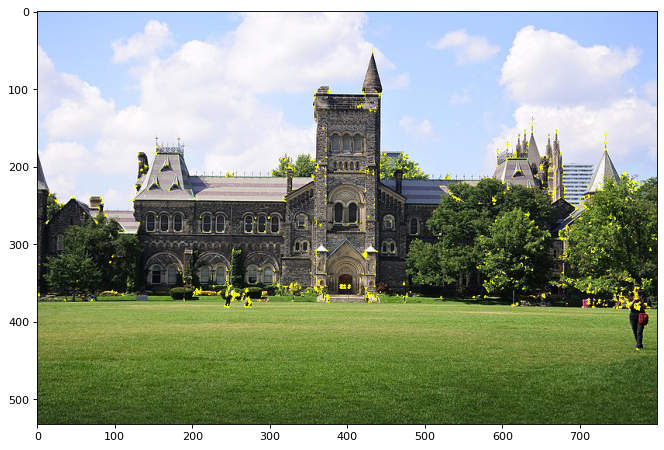

In [ ]:
image = cv2.imread("3_2.jpg")
dims = image.shape
H, W = dims[0], dims[1]

figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')
lambda_1, lambda_2 = eigenvalues(image, 3, 1 ) 

plt.scatter(lambda_1 , lambda_2)
plt.show 
plt.savefig("3_2_7_10_scatter.jpg")

# Let us use the top 3% of eigenvalues, assuming that 3% of the points would be 
# corners 
lambda_1 = np.array(lambda_1)
lambda_1 = lambda_1.reshape((H, W))
lambda_2 = np.array(lambda_2)
lambda_2 = lambda_2.reshape((H, W))

min_lambda = np.minimum(lambda_1 , lambda_2)
percentile = np.percentile(min_lambda,99)

image2 = image.copy()
image2 = cv2.cvtColor(image2, cv2.COLOR_RGB2BGR)
image2[min_lambda > percentile] = [255,255,0]

plt.clf()
plt.imshow(image2)
plt.savefig("3_2_7_10_corners.jpg")


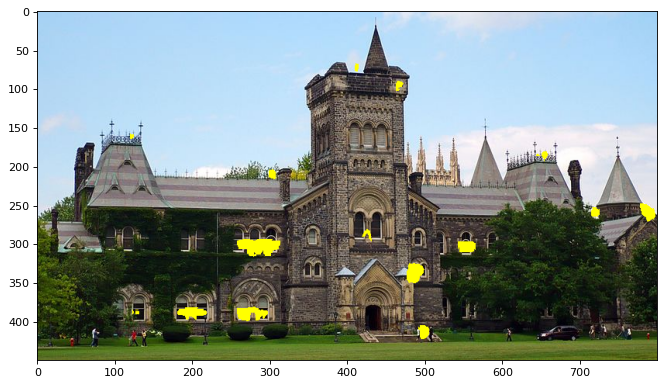

In [ ]:
image = cv2.imread("3_1.jpg")
dims = image.shape
H, W = dims[0], dims[1]

figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')
lambda_1, lambda_2 = eigenvalues(image, 31 , 30 ) 

plt.scatter(lambda_1 , lambda_2)
plt.show 
plt.savefig("3_1_31_30_scatter.jpg")

# Let us use the top 3% of eigenvalues, assuming that 3% of the points would be 
# corners 
lambda_1 = np.array(lambda_1)
lambda_1 = lambda_1.reshape((H, W))
lambda_2 = np.array(lambda_2)
lambda_2 = lambda_2.reshape((H, W))

min_lambda = np.minimum(lambda_1 , lambda_2)
percentile = np.percentile(min_lambda,99)

image2 = image.copy()
image2[min_lambda > percentile] = [0, 255,255]
image2 = cv2.cvtColor(image2, cv2.COLOR_RGB2BGR)

plt.clf()
plt.imshow(image2)
plt.savefig("3_1_31_30_corners.jpg")

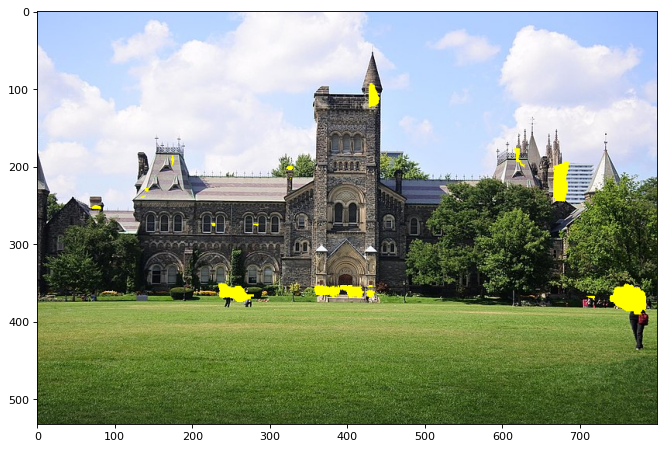

In [ ]:
image = cv2.imread("3_2.jpg")
dims = image.shape
H, W = dims[0], dims[1]

figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')
lambda_1, lambda_2 = eigenvalues(image, 31 , 30 ) 

plt.scatter(lambda_1 , lambda_2)
plt.show 
plt.savefig("3_2_31_30_scatter.jpg")

# Let us use the top 3% of eigenvalues, assuming that 3% of the points would be 
# corners 
lambda_1 = np.array(lambda_1)
lambda_1 = lambda_1.reshape((H, W))
lambda_2 = np.array(lambda_2)
lambda_2 = lambda_2.reshape((H, W))

min_lambda = np.minimum(lambda_1 , lambda_2)
percentile = np.percentile(min_lambda,99)

image2 = image.copy()
image2 = cv2.cvtColor(image2, cv2.COLOR_RGB2BGR)
image2[min_lambda > percentile] = [255,255,0]

plt.clf()
plt.imshow(image2)
plt.savefig("3_2_31_30_corners.jpg")
